In [48]:
import torch
# Check if GPU is available
gpu_available = torch.cuda.is_available()

if gpu_available:
    print("GPU is available!")
    print("GPU Name:", torch.cuda.get_device_name(0))  # Get GPU name if available
else:
    print("GPU is not available.")


GPU is available!
GPU Name: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
import zipfile
import os
import shutil

# Get the current working directory
current_directory = os.getcwd()
zip_path = os.path.join(current_directory, "mimiciii.zip")
extract_folder = current_directory

# Extract the zip file
if os.path.exists(zip_path): 
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)

        # Rename the extracted folder to mimiciii
        extracted_folder_name = os.path.commonprefix(zip_ref.namelist()).strip("/").strip("\\")  
        extracted_path = os.path.join(extract_folder, extracted_folder_name)  
        final_folder = os.path.join(extract_folder, "mimiciii")  
        # Check if the target folder already exists and delete it
        if os.path.exists(final_folder):
            shutil.rmtree(final_folder)  
            
        # Rename the extracted folder
        if os.path.exists(extracted_path):
            os.rename(extracted_path, final_folder)
            print(f"Extracted and renamed folder to: {final_folder}")
        else:
            print("Error: Extracted folder not found.")
else:
    print(f"Error: '{zip_path}' not found in the current directory.")   

Extracted and renamed folder to: d:\sem5\CV\CV Project\Implementation\mimiciii


### Load and Preview MIMIC-III Tables

In [ ]:
import os
import pandas as pd
from tqdm import tqdm

# Path to dataset folder
data_path = final_folder
if not os.path.exists(data_path):
    raise ValueError(f"Data path {data_path} does not exist!")

# Function to load table with optional row limit
def load_table(file_name, data_path, nrows=None):
    file_path = os.path.join(data_path, file_name)
    file_size = os.path.getsize(file_path) / (1024 ** 2) 
    print(f"Loading {file_name} ({file_size:.2f} MB)...")
    return pd.read_csv(file_path, nrows=nrows)

# Load key tables with limited rows for exploration where necessary
admissions_data = load_table("ADMISSIONS.csv", data_path)
patients_data = load_table("PATIENTS.csv", data_path)
icustays_data = load_table("ICUSTAYS.csv", data_path)
labs_data = load_table("LABEVENTS.csv", data_path, nrows=10000)
chart_data = load_table("CHARTEVENTS.csv", data_path, nrows=10000)

# Display previews with info
def preview_table(table, name):
    print(f"\n{name} Table Preview:")
    print(table.head())
    print(f"\n{name} Table Info:")
    print(table.info())
    print(f"\n{name} Table Description (Numeric Columns):")
    print(table.describe(include='all'))

# Preview each table
preview_table(admissions_data, "ADMISSIONS")
preview_table(patients_data, "PATIENTS")
preview_table(icustays_data, "ICUSTAYS")
preview_table(labs_data, "LABEVENTS")
preview_table(chart_data, "CHARTEVENTS")


Loading ADMISSIONS.csv (0.03 MB)...
Loading PATIENTS.csv (0.01 MB)...
Loading ICUSTAYS.csv (0.01 MB)...
Loading LABEVENTS.csv (4.54 MB)...
Loading CHARTEVENTS.csv (74.13 MB)...

ADMISSIONS Table Preview:
   row_id  subject_id  hadm_id            admittime            dischtime  \
0   12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   
1   12263       10011   105331  2126-08-14 22:32:00  2126-08-28 18:59:00   
2   12265       10013   165520  2125-10-04 23:36:00  2125-10-07 15:13:00   
3   12269       10017   199207  2149-05-26 17:19:00  2149-06-03 18:42:00   
4   12270       10019   177759  2163-05-14 20:43:00  2163-05-15 12:00:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   

### Handle Missing Values Across MIMIC-III Tables

In [51]:
# Function to fill missing values for categorical columns
def fill_categorical(df, columns, fill_value):
    for col in columns:
        df[col] = df[col].fillna(fill_value)

# For ADMISSIONS.csv
print("\nMissing Values in ADMISSIONS (Before):")
print(admissions_data.isnull().sum())

fill_categorical(admissions_data, [
    'admission_location', 'discharge_location', 'language', 
    'religion', 'marital_status', 'edregtime', 'edouttime'
], 'Unknown')

print("\nMissing Values in ADMISSIONS (After):")
print(admissions_data.isnull().sum())

# For PATIENTS.csv
print("\nMissing Values in PATIENTS (Before):")
print(patients_data.isnull().sum())

patients_data = patients_data.assign(
    dod=patients_data['dod'].fillna('Not Deceased'),
    dod_hosp=patients_data['dod_hosp'].fillna('Not Available'),
    dod_ssn=patients_data['dod_ssn'].fillna('Not Available')
)

print("\nMissing Values in PATIENTS (After):")
print(patients_data.isnull().sum())

# For ICUSTAYS.csv
print("\nMissing Values in ICUSTAYS (Before):")
print(icustays_data.isnull().sum())

icustays_data = icustays_data.dropna(subset=['intime', 'outtime'])

print("\nMissing Values in ICUSTAYS (After):")
print(icustays_data.isnull().sum())

# For LABEVENTS.csv
print("\nMissing Values in LABEVENTS (Before):")
print(labs_data.isnull().sum())

labs_data['valuenum'] = labs_data['valuenum'].ffill().bfill()
print("\nMissing Values in LABEVENTS (After):")
print(labs_data.isnull().sum())

# For CHARTEVENTS.csv
print("\nMissing Values in CHARTEVENTS (Before):")
print(chart_data.isnull().sum())

chart_data['valuenum'] = chart_data['valuenum'].ffill().bfill()
chart_data = chart_data.drop(columns=['resultstatus', 'stopped'], errors='ignore')

print("\nMissing Values in CHARTEVENTS (After):")
print(chart_data.isnull().sum())



Missing Values in ADMISSIONS (Before):
row_id                   0
subject_id               0
hadm_id                  0
admittime                0
dischtime                0
deathtime               89
admission_type           0
admission_location       0
discharge_location       0
insurance                0
language                48
religion                 1
marital_status          16
ethnicity                0
edregtime               37
edouttime               37
diagnosis                0
hospital_expire_flag     0
has_chartevents_data     0
dtype: int64

Missing Values in ADMISSIONS (After):
row_id                   0
subject_id               0
hadm_id                  0
admittime                0
dischtime                0
deathtime               89
admission_type           0
admission_location       0
discharge_location       0
insurance                0
language                 0
religion                 0
marital_status           0
ethnicity                0
edregtime        

### Feature Normalization and Group Mapping

In [52]:
from sklearn.preprocessing import StandardScaler

# Normalize VALUENUM in LABEVENTS and CHARTEVENTS
lab_scaler = StandardScaler()
chart_scaler = StandardScaler()

labs_data['valuenum'] = labs_data['valuenum'].fillna(0) 
chart_data['valuenum'] = chart_data['valuenum'].fillna(0)

labs_data['valuenum'] = lab_scaler.fit_transform(labs_data[['valuenum']])
chart_data['valuenum'] = chart_scaler.fit_transform(chart_data[['valuenum']])

# Display normalized data
print("\nNormalized LABEVENTS (First 5 Rows):")
print(labs_data.head())
print("\nNormalized CHARTEVENTS (First 5 Rows):")
print(chart_data.head())

# Load dictionaries
d_items = pd.read_csv(os.path.join(data_path, "D_ITEMS.csv"))
d_labitems = pd.read_csv(os.path.join(data_path, "D_LABITEMS.csv"))

print("D_ITEMS Preview:")
print(d_items.head())
print("\nD_LABITEMS Preview:")
print(d_labitems.head())

def map_features(label):
    if pd.isnull(label):
        return 'Other'
    label = label.lower()
    if 'heart' in label or 'bp' in label or 'pressure' in label or 'cardiac' in label:
        return 'Cardiac'
    elif 'respiratory' in label or 'oxygen' in label or 'spo2' in label or 'ventilation' in label:
        return 'Respiratory'
    elif 'glucose' in label or 'potassium' in label or 'sodium' in label or 'chloride' in label or 'bicarbonate' in label or 'co2' in label:
        return 'Metabolic'
    elif 'temperature' in label or 'thermometer' in label:
        return 'Temperature'
    elif 'tremor' in label or 'nystagmus' in label:
        return 'Neurological'
    return 'Other'


d_items['group'] = d_items['label'].apply(map_features)
d_labitems['group'] = d_labitems['label'].apply(map_features)
unmapped_labitems = d_labitems[d_labitems['group'] == 'Other']
unmapped_items = d_items[d_items['group'] == 'Other']

print("\nUnmapped LABITEMS (First 10 Rows):")
print(unmapped_labitems.head(10))
print("\nUnmapped ITEMS (First 10 Rows):")
print(unmapped_items.head(10))

# Clean dictionaries
d_items_clean = d_items[['itemid', 'group']].drop_duplicates()
d_labitems_clean = d_labitems[['itemid', 'group']].drop_duplicates()

# Map and merge function
def map_and_merge(data, map_df, key='itemid', group_col='group'):
    data = data.drop(columns=[group_col], errors='ignore')
    data = data.merge(map_df, on=key, how='left')
    data[group_col] = data[group_col].fillna('Other')
    return data

labs_data = map_and_merge(labs_data, d_labitems_clean, 'itemid', 'group')
chart_data = map_and_merge(chart_data, d_items_clean, 'itemid', 'group')

# Log grouping distribution
print("\nLABEVENTS Grouping Distribution:")
print(labs_data['group'].value_counts(normalize=True) * 100)
print("\nCHARTEVENTS Grouping Distribution:")
print(chart_data['group'].value_counts(normalize=True) * 100)

# Display updated grouping
print("\nLABEVENTS with Updated Grouping (First 5 Rows):")
print(labs_data.head())
print("\nCHARTEVENTS with Updated Grouping (First 5 Rows):")
print(chart_data.head())



Normalized LABEVENTS (First 5 Rows):
    row_id  subject_id  hadm_id  itemid            charttime value  valuenum  \
0  6244563       10006      NaN   50868  2164-09-24 20:21:00    19 -0.159129   
1  6244564       10006      NaN   50882  2164-09-24 20:21:00    27 -0.126499   
2  6244565       10006      NaN   50893  2164-09-24 20:21:00  10.0 -0.195836   
3  6244566       10006      NaN   50902  2164-09-24 20:21:00    97  0.159005   
4  6244567       10006      NaN   50912  2164-09-24 20:21:00   7.0 -0.208072   

  valueuom      flag  
0    mEq/L       NaN  
1    mEq/L       NaN  
2    mg/dL       NaN  
3    mEq/L       NaN  
4    mg/dL  abnormal  

Normalized CHARTEVENTS (First 5 Rows):
    row_id  subject_id  hadm_id  icustay_id  itemid            charttime  \
0  5279021       40124   126179    279554.0  223761  2130-02-04 04:00:00   
1  5279022       40124   126179    279554.0  224695  2130-02-04 04:25:00   
2  5279023       40124   126179    279554.0  220210  2130-02-04 04:30:00   

### Combine Patient and Time-Series Data

In [53]:
save_data = True 
labs_data = labs_data.rename(columns={"row_id": "row_id_lab"})
chart_data = chart_data.rename(columns={"row_id": "row_id_chart"})

# Merge ADMISSIONS, PATIENTS, and ICUSTAYS into a patient-level table
patient_data = admissions_data.merge(patients_data, on='subject_id', how='inner')
patient_data = patient_data.merge(icustays_data, on=['subject_id', 'hadm_id'], how='inner')

print("\nCombined Patient-Level Table:")
print(patient_data.head())

if save_data:
    patient_data.to_csv("cleaned_patient_data.csv", index=False)
    print("Patient-level table saved as 'cleaned_patient_data.csv'.")

# Merge time-series data (LABEVENTS and CHARTEVENTS) with patient-level table
labs_merged = labs_data.merge(patient_data, on='subject_id', how='inner', suffixes=('_lab', '_patient'))
chart_merged = chart_data.merge(patient_data, on='subject_id', how='inner', suffixes=('_chart', '_patient'))

# Combine LABEVENTS and CHARTEVENTS into a single time-series table
combined_timeseries = pd.concat([labs_merged, chart_merged]).sort_values(by=['subject_id', 'charttime'])

# Save the combined time-series table
if save_data:
    combined_timeseries.to_csv("combined_timeseries_data.csv", index=False)
    print("Combined time-series table saved as 'combined_timeseries_data.csv'.")

# Verify and log table shapes
print("\nPatient-Level Table Shape:", patient_data.shape)
print("LABEVENTS Merged Table Shape:", labs_merged.shape)
print("CHARTEVENTS Merged Table Shape:", chart_merged.shape)
print("Time-Series Table Shape:", combined_timeseries.shape)
print("\nMissing Values in Combined Time-Series Data:")
print(combined_timeseries.isnull().sum())
print("\nSample of Combined Time-Series Data:")
print(combined_timeseries.head())
zero_percentage_valuenum = (combined_timeseries['valuenum'] == 0).mean() * 100
print(f"Percentage of zeros in VALUENUM: {zero_percentage_valuenum:.2f}%")
missing_percentage_valuenum = combined_timeseries['valuenum'].isnull().mean() * 100
print(f"Percentage of missing values in VALUENUM: {missing_percentage_valuenum:.2f}%")
print("\nVALUENUM Statistics:")
print(combined_timeseries['valuenum'].describe())



Combined Patient-Level Table:
   row_id_x  subject_id  hadm_id            admittime            dischtime  \
0     12258       10006   142345  2164-10-23 21:09:00  2164-11-01 17:15:00   
1     12263       10011   105331  2126-08-14 22:32:00  2126-08-28 18:59:00   
2     12265       10013   165520  2125-10-04 23:36:00  2125-10-07 15:13:00   
3     12269       10017   199207  2149-05-26 17:19:00  2149-06-03 18:42:00   
4     12270       10019   177759  2163-05-14 20:43:00  2163-05-15 12:00:00   

             deathtime admission_type         admission_location  \
0                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1  2126-08-28 18:59:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
2  2125-10-07 15:13:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   
3                  NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
4  2163-05-15 12:00:00      EMERGENCY  TRANSFER FROM HOSP/EXTRAM   

  discharge_location insurance  ... row_id icustay_id dbsource first_careunit  \
0   HOME H

### Generate Temporal Contrastive Pairs

In [ ]:
import pandas as pd
import numpy as np
import torch

# Load the combined timeseries data
combined_data = pd.read_csv("combined_timeseries_data.csv")

# Sort the data by subject and time for sequential processing
combined_data = combined_data.sort_values(by=['subject_id', 'charttime']).dropna(subset=['valuenum'])

print("Combined Feature Data (Sorted by Subject and Time):")
print(combined_data.head())

# Function to generate temporal contrastive pairs
def generate_temporal_pairs(data, window_size=5, num_negative_samples=500):
    positive_pairs = []
    negative_pairs = []

    # Group data by 'subject_id' (patient level)
    grouped = data.groupby('subject_id')
    other_subjects = data.sample(frac=0.1, random_state=42)  
    for subject_id, group_data in grouped:
        values = group_data['valuenum'].values

        for i in range(len(values) - window_size):
            window_1 = values[i:i + window_size]
            window_2 = values[i + 1:i + 1 + window_size] 
            positive_pairs.append((window_1, window_2, 1))

        # Generate negative pairs
        for _ in range(num_negative_samples):
            random_window = other_subjects.sample(window_size)['valuenum'].values
            positive_window = window_1
            negative_pairs.append((positive_window, random_window, 0))

    print(f"Generated {len(positive_pairs)} positive pairs and {len(negative_pairs)} negative pairs.")
    return positive_pairs, negative_pairs

# Generate pairs
positive_pairs, negative_pairs = generate_temporal_pairs(combined_data, window_size=5, num_negative_samples=500)

# Debugging: Check for zeros in pairs
def check_zeros_in_pairs(pairs, name):
    zero_x1 = sum([np.allclose(pair[0], 0) for pair in pairs]) / len(pairs) * 100
    zero_x2 = sum([np.allclose(pair[1], 0) for pair in pairs]) / len(pairs) * 100
    print(f"{name}: Zero percentage in x1: {zero_x1:.2f}%, x2: {zero_x2:.2f}%")

check_zeros_in_pairs(positive_pairs, "Positive Pairs")
check_zeros_in_pairs(negative_pairs, "Negative Pairs")

# Convert pairs to DataFrame for saving
def pair_to_dataframe(pairs, label_column='label'):
    data = []
    for pair in pairs:
        data.append({'x1': list(pair[0]), 'x2': list(pair[1]), label_column: pair[2]})
    return pd.DataFrame(data)

positive_df = pair_to_dataframe(positive_pairs)
negative_df = pair_to_dataframe(negative_pairs)

# Save the pairs with timestamps
timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
positive_df.to_csv(f"positive_temporal_pairs.csv", index=False)
negative_df.to_csv(f"negative_temporal_pairs.csv", index=False)

print("\nPositive Pairs Example:")
print(positive_df.head())
print("\nNegative Pairs Example:")
print(negative_df.head())
print("Temporal positive and negative pairs saved successfully.")


Combined Feature Data (Sorted by Subject and Time):
   row_id_lab  subject_id  hadm_id_lab  itemid            charttime value  \
0   6244563.0       10006          NaN   50868  2164-09-24 20:21:00    19   
1   6244564.0       10006          NaN   50882  2164-09-24 20:21:00    27   
2   6244565.0       10006          NaN   50893  2164-09-24 20:21:00  10.0   
3   6244566.0       10006          NaN   50902  2164-09-24 20:21:00    97   
4   6244567.0       10006          NaN   50912  2164-09-24 20:21:00   7.0   

   valuenum valueuom      flag      group  ...              outtime     los  \
0 -0.159129    mEq/L       NaN      Other  ...  2164-10-25 12:21:07  1.6325   
1 -0.126499    mEq/L       NaN  Metabolic  ...  2164-10-25 12:21:07  1.6325   
2 -0.195836    mg/dL       NaN      Other  ...  2164-10-25 12:21:07  1.6325   
3  0.159005    mEq/L       NaN  Metabolic  ...  2164-10-25 12:21:07  1.6325   
4 -0.208072    mg/dL  abnormal      Other  ...  2164-10-25 12:21:07  1.6325   

  row_id_c

C:\Users\bilal\AppData\Local\Temp\ipykernel_12124\815659546.py:6: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_data = pd.read_csv("combined_timeseries_data.csv")


Generated 28994 positive pairs and 12500 negative pairs.
Positive Pairs: Zero percentage in x1: 0.00%, x2: 0.00%
Negative Pairs: Zero percentage in x1: 0.00%, x2: 0.00%

Positive Pairs Example:
                                                  x1  \
0  [-0.1591285545383133, -0.1264994657041942, -0....   
1  [-0.1264994657041942, -0.1958362794766974, 0.1...   
2  [-0.1958362794766974, 0.1590050615943484, -0.2...   
3  [0.1590050615943484, -0.2080721877894921, 0.27...   
4  [-0.2080721877894921, 0.2772855086180303, -0.2...   

                                                  x2  label  
0  [-0.1264994657041942, -0.1958362794766974, 0.1...      1  
1  [-0.1958362794766974, 0.1590050615943484, -0.2...      1  
2  [0.1590050615943484, -0.2080721877894921, 0.27...      1  
3  [-0.2080721877894921, 0.2772855086180303, -0.2...      1  
4  [0.2772855086180303, -0.2272417774795371, -0.2...      1  

Negative Pairs Example:
                                                  x1  \
0  [-0.222755277

### Prepare Temporal Contrastive Dataset

In [55]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import torch
import ast
import re
#Load Temporal Positive and Negative Pairs
positive_pairs = pd.read_csv("positive_temporal_pairs.csv")
negative_pairs = pd.read_csv("negative_temporal_pairs.csv")

print("\nPositive Temporal Pairs Loaded:")
print(positive_pairs.head())

print("\nNegative Temporal Pairs Loaded:")
print(negative_pairs.head())

#Combine Positive and Negative Pairs with Labels
positive_pairs['label'] = 1
negative_pairs['label'] = 0

contrastive_data = pd.concat([positive_pairs[['x1', 'x2', 'label']],
                              negative_pairs[['x1', 'x2', 'label']]])

print(f"\nRows in combined dataset before preprocessing: {len(contrastive_data)}")
def clean_and_eval(val):
    try:
        cleaned_val = re.sub(r'np\.float64\((.*?)\)', r'\1', val)
        return ast.literal_eval(cleaned_val)
    except Exception as e:
        print(f"Error parsing value: {val}\nError: {e}")
        return [] #if it fails
    
# Apply to x1 and x2 columns
contrastive_data['x1'] = contrastive_data['x1'].apply(clean_and_eval)
contrastive_data['x2'] = contrastive_data['x2'].apply(clean_and_eval)

# Debug: Check for zeros before filtering
zero_x1 = contrastive_data['x1'].apply(lambda x: np.allclose(x, 0)).mean() * 100
zero_x2 = contrastive_data['x2'].apply(lambda x: np.allclose(x, 0)).mean() * 100
print(f"Zero percentage before filtering: x1: {zero_x1:.2f}%, x2: {zero_x2:.2f}%")

# Drop rows where x1 or x2 is an empty list
contrastive_data.dropna(subset=['x1', 'x2'], inplace=True)
print(f"Rows after preprocessing: {len(contrastive_data)}")

# Debug: Check for zeros after filtering
zero_x1 = contrastive_data['x1'].apply(lambda x: np.allclose(x, 0)).mean() * 100
zero_x2 = contrastive_data['x2'].apply(lambda x: np.allclose(x, 0)).mean() * 100
print(f"Zero percentage after filtering: x1: {zero_x1:.2f}%, x2: {zero_x2:.2f}%")

#Define Temporal Contrastive Dataset
class TemporalContrastiveDataset(Dataset):
    def __init__(self, data, window_size=5):
        self.x1 = data['x1'].values
        self.x2 = data['x2'].values
        self.labels = data['label'].values
        self.window_size = window_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x1 = self.x1[idx]
        x2 = self.x2[idx]
        label = self.labels[idx]
        
        # Pad or truncate to fixed length
        x1 = np.pad(x1, (0, self.window_size - len(x1)), 'constant', constant_values=0)[:self.window_size]
        x2 = np.pad(x2, (0, self.window_size - len(x2)), 'constant', constant_values=0)[:self.window_size]
        
        # Convert to tensors
        x1 = torch.tensor(x1, dtype=torch.float32)
        x2 = torch.tensor(x2, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32).unsqueeze(0)  # Add a batch dimension to label
        
        return x1, x2, label


#Create Dataset and DataLoader
window_size = 5  # Define the window size for each sequence
dataset = TemporalContrastiveDataset(contrastive_data, window_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#Verify DataLoader Output with Limited Debugging
print("\nSample Batch from DataLoader:")

max_batches_to_log = 2  # Limit debug output to first 2 batches
batch_count = 0

for x1, x2, label in dataloader:
    batch_count += 1
    print(f"Batch {batch_count}: x1 Shape: {x1.shape}, x2 Shape: {x2.shape}, Labels: {label[:5]}")
    print(f"x1[0]: {x1[0]}")  
    print(f"x2[0]: {x2[0]}") 
    if batch_count >= max_batches_to_log:
        break


Positive Temporal Pairs Loaded:
                                                  x1  \
0  [np.float64(-0.1591285545383133), np.float64(-...   
1  [np.float64(-0.1264994657041942), np.float64(-...   
2  [np.float64(-0.1958362794766974), np.float64(0...   
3  [np.float64(0.1590050615943484), np.float64(-0...   
4  [np.float64(-0.2080721877894921), np.float64(0...   

                                                  x2  label  
0  [np.float64(-0.1264994657041942), np.float64(-...      1  
1  [np.float64(-0.1958362794766974), np.float64(0...      1  
2  [np.float64(0.1590050615943484), np.float64(-0...      1  
3  [np.float64(-0.2080721877894921), np.float64(0...      1  
4  [np.float64(0.2772855086180303), np.float64(-0...      1  

Negative Temporal Pairs Loaded:
                                                  x1  \
0  [np.float64(-0.2227552777648457), np.float64(-...   
1  [np.float64(-0.2227552777648457), np.float64(-...   
2  [np.float64(-0.2227552777648457), np.float64(-...   
3

### Define Contrastive LSTM Model

In [56]:
import torch
import torch.nn as nn

# LSTM-Based Contrastive Model
class ContrastiveLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.3, bidirectional=False):
        super(ContrastiveLSTMModel, self).__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=bidirectional)
        self.projection_head = nn.Sequential(
            nn.Linear(hidden_dim * (2 if bidirectional else 1), hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
            nn.BatchNorm1d(output_dim)
        )
    def forward(self, x):
        if x.dim() == 2: 
            x = x.unsqueeze(-1)
        lstm_out, (hidden, _) = self.lstm(x)  
        if self.bidirectional:
            num_layers = self.lstm.num_layers
            hidden = hidden.view(num_layers, 2, hidden.size(1), hidden.size(2))
            hidden = torch.cat((hidden[-1, 0], hidden[-1, 1]), dim=1) 
        else:
            hidden = hidden[-1]  
        embeddings = self.projection_head(hidden) 
        return embeddings

# Model Initialization
input_dim = 1        
hidden_dim = 64      
output_dim = 32      
num_layers = 2      
dropout = 0.3
bidirectional = True 
model = ContrastiveLSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout, bidirectional)
from torchinfo import summary
summary(model, input_size=(32, 5, 1))  

Layer (type:depth-idx)                   Output Shape              Param #
ContrastiveLSTMModel                     [32, 32]                  --
├─LSTM: 1-1                              [32, 5, 128]              133,632
├─Sequential: 1-2                        [32, 32]                  --
│    └─Linear: 2-1                       [32, 64]                  8,256
│    └─BatchNorm1d: 2-2                  [32, 64]                  128
│    └─ReLU: 2-3                         [32, 64]                  --
│    └─Dropout: 2-4                      [32, 64]                  --
│    └─Linear: 2-5                       [32, 32]                  2,080
│    └─BatchNorm1d: 2-6                  [32, 32]                  64
Total params: 144,160
Trainable params: 144,160
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 21.72
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.58
Estimated Total Size (MB): 0.79

### Data Augmentation

In [57]:
import torch
import random
def data_augmentation(x, noise_std=0.1, scale_min=0.8, scale_max=1.2, mask_prob=0.1):
    noise = torch.randn_like(x) * noise_std
    scale = torch.empty(x.size(0), 1, 1, device=x.device).uniform_(scale_min, scale_max)
    x = x * scale + noise
    mask = torch.bernoulli(torch.full((x.size(0), x.size(1), 1), 1 - mask_prob, device=x.device))
    x = x * mask  
    return x

### NT-Xent Loss

In [58]:
import torch
import torch.nn as nn

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.07, eps=1e-8, hard_negative_threshold=0.3):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.eps = eps
        self.hard_negative_threshold = hard_negative_threshold

    def forward(self, z1, z2, label):
        # Normalize embeddings
        z1 = z1 / (torch.norm(z1, dim=-1, keepdim=True) + self.eps)
        z2 = z2 / (torch.norm(z2, dim=-1, keepdim=True) + self.eps)

        # Compute cosine similarity
        sim = torch.mm(z1, z2.t()) / self.temperature  
        sim = torch.clamp(sim, min=-1.0, max=1.0)

        # Masks for positive and negative pairs
        positive_mask = torch.eye(sim.size(0), device=sim.device).bool()  
        negative_mask = ~positive_mask  

        # Debugging: Check for NaNs in cosine similarity
        if torch.isnan(sim).any():
            print("NaNs detected in cosine similarity matrix!")
            return torch.tensor(float('nan'), device=sim.device)

        # Positive Loss
        exp_sim = torch.exp(sim) 
        positive_loss = -torch.log(exp_sim[positive_mask] / (exp_sim.sum(dim=1) + self.eps)).mean()

        # Hard Negative Loss
        hard_negative_mask = negative_mask & (sim > self.hard_negative_threshold)
        if hard_negative_mask.sum() > 0:  # If hard negatives exist
            negative_loss = -torch.log(1 - sim[hard_negative_mask] + self.eps).mean()
        else:
            negative_loss = torch.tensor(0.0, device=sim.device)

        # Total Loss
        total_loss = positive_loss + negative_loss

        return total_loss


### Training Loop with Optimizer, Scheduler, and Data Augmentation

Using device: cuda
Verifying dataset...
Sample 0: x1 shape torch.Size([5]), x2 shape torch.Size([5]), label shape torch.Size([1])
Setting up DataLoaders...
Starting Training...

Epoch 1/100 - Training Phase Started...


Training Epoch 1: 100%|██████████| 519/519 [00:05<00:00, 95.66it/s] 



Epoch 1/100 - Validation Phase Started...


Validation Epoch 1: 100%|██████████| 130/130 [00:00<00:00, 135.90it/s]


Epoch 1/100 | Training Loss: 5.5309 | Validation Loss: 22.2825 | Learning Rate: 0.000213 | Time: 6.38s

Epoch 2/100 - Training Phase Started...


Training Epoch 2: 100%|██████████| 519/519 [00:05<00:00, 98.06it/s] 



Epoch 2/100 - Validation Phase Started...


Validation Epoch 2: 100%|██████████| 130/130 [00:00<00:00, 167.23it/s]


Epoch 2/100 | Training Loss: 5.2985 | Validation Loss: 21.5357 | Learning Rate: 0.000252 | Time: 6.08s

Epoch 3/100 - Training Phase Started...


Training Epoch 3: 100%|██████████| 519/519 [00:05<00:00, 97.50it/s] 



Epoch 3/100 - Validation Phase Started...


Validation Epoch 3: 100%|██████████| 130/130 [00:00<00:00, 150.04it/s]


Epoch 3/100 | Training Loss: 5.2534 | Validation Loss: 20.8676 | Learning Rate: 0.000317 | Time: 6.19s

Epoch 4/100 - Training Phase Started...


Training Epoch 4: 100%|██████████| 519/519 [00:05<00:00, 94.47it/s] 



Epoch 4/100 - Validation Phase Started...


Validation Epoch 4: 100%|██████████| 130/130 [00:00<00:00, 189.43it/s]


Epoch 4/100 | Training Loss: 5.2197 | Validation Loss: 20.9104 | Learning Rate: 0.000408 | Time: 6.18s

Epoch 5/100 - Training Phase Started...


Training Epoch 5: 100%|██████████| 519/519 [00:05<00:00, 96.50it/s] 



Epoch 5/100 - Validation Phase Started...


Validation Epoch 5: 100%|██████████| 130/130 [00:00<00:00, 153.76it/s]


Epoch 5/100 | Training Loss: 5.1961 | Validation Loss: 20.8797 | Learning Rate: 0.000522 | Time: 6.23s

Epoch 6/100 - Training Phase Started...


Training Epoch 6: 100%|██████████| 519/519 [00:05<00:00, 90.37it/s] 



Epoch 6/100 - Validation Phase Started...


Validation Epoch 6: 100%|██████████| 130/130 [00:00<00:00, 194.72it/s]


Epoch 6/100 | Training Loss: 5.2054 | Validation Loss: 20.9642 | Learning Rate: 0.000658 | Time: 6.41s

Epoch 7/100 - Training Phase Started...


Training Epoch 7: 100%|██████████| 519/519 [00:07<00:00, 71.59it/s] 



Epoch 7/100 - Validation Phase Started...


Validation Epoch 7: 100%|██████████| 130/130 [00:02<00:00, 48.56it/s]


Epoch 7/100 | Training Loss: 5.1937 | Validation Loss: 20.4786 | Learning Rate: 0.000817 | Time: 9.93s

Epoch 8/100 - Training Phase Started...


Training Epoch 8: 100%|██████████| 519/519 [00:25<00:00, 20.02it/s]



Epoch 8/100 - Validation Phase Started...


Validation Epoch 8: 100%|██████████| 130/130 [00:02<00:00, 53.63it/s]


Epoch 8/100 | Training Loss: 5.2003 | Validation Loss: 20.0584 | Learning Rate: 0.000994 | Time: 28.36s

Epoch 9/100 - Training Phase Started...


Training Epoch 9: 100%|██████████| 519/519 [00:24<00:00, 21.26it/s]



Epoch 9/100 - Validation Phase Started...


Validation Epoch 9: 100%|██████████| 130/130 [00:02<00:00, 43.92it/s]


Epoch 9/100 | Training Loss: 5.2113 | Validation Loss: 20.0109 | Learning Rate: 0.001189 | Time: 27.37s

Epoch 10/100 - Training Phase Started...


Training Epoch 10: 100%|██████████| 519/519 [00:09<00:00, 53.15it/s] 



Epoch 10/100 - Validation Phase Started...


Validation Epoch 10: 100%|██████████| 130/130 [00:00<00:00, 152.49it/s]


Epoch 10/100 | Training Loss: 5.2056 | Validation Loss: 19.8801 | Learning Rate: 0.001400 | Time: 10.63s

Epoch 11/100 - Training Phase Started...


Training Epoch 11: 100%|██████████| 519/519 [00:05<00:00, 96.63it/s] 



Epoch 11/100 - Validation Phase Started...


Validation Epoch 11: 100%|██████████| 130/130 [00:00<00:00, 156.43it/s]


Epoch 11/100 | Training Loss: 5.2153 | Validation Loss: 19.7443 | Learning Rate: 0.001624 | Time: 6.21s

Epoch 12/100 - Training Phase Started...


Training Epoch 12: 100%|██████████| 519/519 [00:05<00:00, 100.86it/s]



Epoch 12/100 - Validation Phase Started...


Validation Epoch 12: 100%|██████████| 130/130 [00:00<00:00, 147.01it/s]


Epoch 12/100 | Training Loss: 5.2186 | Validation Loss: 20.3256 | Learning Rate: 0.001859 | Time: 6.03s

Epoch 13/100 - Training Phase Started...


Training Epoch 13: 100%|██████████| 519/519 [00:05<00:00, 95.00it/s] 



Epoch 13/100 - Validation Phase Started...


Validation Epoch 13: 100%|██████████| 130/130 [00:00<00:00, 162.45it/s]


Epoch 13/100 | Training Loss: 5.2247 | Validation Loss: 19.6981 | Learning Rate: 0.002101 | Time: 6.26s

Epoch 14/100 - Training Phase Started...


Training Epoch 14: 100%|██████████| 519/519 [00:04<00:00, 105.39it/s]



Epoch 14/100 - Validation Phase Started...


Validation Epoch 14: 100%|██████████| 130/130 [00:00<00:00, 144.16it/s]


Epoch 14/100 | Training Loss: 5.2150 | Validation Loss: 19.1371 | Learning Rate: 0.002349 | Time: 5.84s

Epoch 15/100 - Training Phase Started...


Training Epoch 15: 100%|██████████| 519/519 [00:05<00:00, 98.96it/s] 



Epoch 15/100 - Validation Phase Started...


Validation Epoch 15: 100%|██████████| 130/130 [00:00<00:00, 155.33it/s]


Epoch 15/100 | Training Loss: 5.2094 | Validation Loss: 19.2083 | Learning Rate: 0.002600 | Time: 6.08s

Epoch 16/100 - Training Phase Started...


Training Epoch 16: 100%|██████████| 519/519 [00:05<00:00, 87.62it/s] 



Epoch 16/100 - Validation Phase Started...


Validation Epoch 16: 100%|██████████| 130/130 [00:00<00:00, 147.73it/s]


Epoch 16/100 | Training Loss: 5.2072 | Validation Loss: 19.2794 | Learning Rate: 0.002851 | Time: 6.81s

Epoch 17/100 - Training Phase Started...


Training Epoch 17: 100%|██████████| 519/519 [00:05<00:00, 91.78it/s] 



Epoch 17/100 - Validation Phase Started...


Validation Epoch 17: 100%|██████████| 130/130 [00:00<00:00, 185.68it/s]


Epoch 17/100 | Training Loss: 5.2116 | Validation Loss: 18.8291 | Learning Rate: 0.003099 | Time: 6.36s

Epoch 18/100 - Training Phase Started...


Training Epoch 18: 100%|██████████| 519/519 [00:05<00:00, 94.78it/s] 



Epoch 18/100 - Validation Phase Started...


Validation Epoch 18: 100%|██████████| 130/130 [00:00<00:00, 173.32it/s]


Epoch 18/100 | Training Loss: 5.2142 | Validation Loss: 18.9904 | Learning Rate: 0.003342 | Time: 6.23s

Epoch 19/100 - Training Phase Started...


Training Epoch 19: 100%|██████████| 519/519 [00:05<00:00, 93.64it/s] 



Epoch 19/100 - Validation Phase Started...


Validation Epoch 19: 100%|██████████| 130/130 [00:00<00:00, 195.31it/s]


Epoch 19/100 | Training Loss: 5.2001 | Validation Loss: 18.9693 | Learning Rate: 0.003576 | Time: 6.21s

Epoch 20/100 - Training Phase Started...


Training Epoch 20: 100%|██████████| 519/519 [00:05<00:00, 88.13it/s] 



Epoch 20/100 - Validation Phase Started...


Validation Epoch 20: 100%|██████████| 130/130 [00:00<00:00, 188.77it/s]


Epoch 20/100 | Training Loss: 5.1790 | Validation Loss: 18.0467 | Learning Rate: 0.003800 | Time: 6.58s

Epoch 21/100 - Training Phase Started...


Training Epoch 21: 100%|██████████| 519/519 [00:05<00:00, 89.50it/s]



Epoch 21/100 - Validation Phase Started...


Validation Epoch 21: 100%|██████████| 130/130 [00:00<00:00, 175.82it/s]


Epoch 21/100 | Training Loss: 5.1717 | Validation Loss: 18.5842 | Learning Rate: 0.004011 | Time: 6.54s

Epoch 22/100 - Training Phase Started...


Training Epoch 22: 100%|██████████| 519/519 [00:05<00:00, 88.17it/s]



Epoch 22/100 - Validation Phase Started...


Validation Epoch 22: 100%|██████████| 130/130 [00:00<00:00, 188.98it/s]


Epoch 22/100 | Training Loss: 5.1602 | Validation Loss: 18.4996 | Learning Rate: 0.004206 | Time: 6.60s

Epoch 23/100 - Training Phase Started...


Training Epoch 23: 100%|██████████| 519/519 [00:05<00:00, 88.47it/s]



Epoch 23/100 - Validation Phase Started...


Validation Epoch 23: 100%|██████████| 130/130 [00:00<00:00, 181.77it/s]


Epoch 23/100 | Training Loss: 5.1547 | Validation Loss: 18.6247 | Learning Rate: 0.004384 | Time: 6.58s

Epoch 24/100 - Training Phase Started...


Training Epoch 24: 100%|██████████| 519/519 [00:05<00:00, 89.01it/s]



Epoch 24/100 - Validation Phase Started...


Validation Epoch 24: 100%|██████████| 130/130 [00:00<00:00, 175.18it/s]


Epoch 24/100 | Training Loss: 5.1503 | Validation Loss: 19.4357 | Learning Rate: 0.004542 | Time: 6.57s

Epoch 25/100 - Training Phase Started...


Training Epoch 25: 100%|██████████| 519/519 [00:05<00:00, 101.77it/s]



Epoch 25/100 - Validation Phase Started...


Validation Epoch 25: 100%|██████████| 130/130 [00:00<00:00, 197.63it/s]


Epoch 25/100 | Training Loss: 5.1385 | Validation Loss: 19.3159 | Learning Rate: 0.004679 | Time: 5.76s

Epoch 26/100 - Training Phase Started...


Training Epoch 26: 100%|██████████| 519/519 [00:05<00:00, 99.69it/s] 



Epoch 26/100 - Validation Phase Started...


Validation Epoch 26: 100%|██████████| 130/130 [00:00<00:00, 189.37it/s]


Epoch 26/100 | Training Loss: 5.1294 | Validation Loss: 19.7063 | Learning Rate: 0.004793 | Time: 5.89s

Epoch 27/100 - Training Phase Started...


Training Epoch 27: 100%|██████████| 519/519 [00:05<00:00, 101.18it/s]



Epoch 27/100 - Validation Phase Started...


Validation Epoch 27: 100%|██████████| 130/130 [00:00<00:00, 167.46it/s]


Epoch 27/100 | Training Loss: 5.1193 | Validation Loss: 19.7013 | Learning Rate: 0.004883 | Time: 5.91s

Epoch 28/100 - Training Phase Started...


Training Epoch 28: 100%|██████████| 519/519 [00:05<00:00, 95.70it/s] 



Epoch 28/100 - Validation Phase Started...


Validation Epoch 28: 100%|██████████| 130/130 [00:00<00:00, 182.78it/s]


Epoch 28/100 | Training Loss: 5.1231 | Validation Loss: 19.5033 | Learning Rate: 0.004948 | Time: 6.14s

Epoch 29/100 - Training Phase Started...


Training Epoch 29: 100%|██████████| 519/519 [00:05<00:00, 87.59it/s]



Epoch 29/100 - Validation Phase Started...


Validation Epoch 29: 100%|██████████| 130/130 [00:00<00:00, 185.20it/s]


Epoch 29/100 | Training Loss: 5.1179 | Validation Loss: 19.4044 | Learning Rate: 0.004987 | Time: 6.64s

Epoch 30/100 - Training Phase Started...


Training Epoch 30: 100%|██████████| 519/519 [00:05<00:00, 95.76it/s] 



Epoch 30/100 - Validation Phase Started...


Validation Epoch 30: 100%|██████████| 130/130 [00:00<00:00, 153.15it/s]


Epoch 30/100 | Training Loss: 5.1106 | Validation Loss: 19.2994 | Learning Rate: 0.005000 | Time: 6.28s

Epoch 31/100 - Training Phase Started...


Training Epoch 31: 100%|██████████| 519/519 [00:05<00:00, 93.85it/s] 



Epoch 31/100 - Validation Phase Started...


Validation Epoch 31: 100%|██████████| 130/130 [00:00<00:00, 150.71it/s]


Epoch 31/100 | Training Loss: 5.1100 | Validation Loss: 20.0072 | Learning Rate: 0.004997 | Time: 6.39s

Epoch 32/100 - Training Phase Started...


Training Epoch 32: 100%|██████████| 519/519 [00:05<00:00, 92.13it/s]



Epoch 32/100 - Validation Phase Started...


Validation Epoch 32: 100%|██████████| 130/130 [00:00<00:00, 173.22it/s]


Epoch 32/100 | Training Loss: 5.1126 | Validation Loss: 20.0991 | Learning Rate: 0.004990 | Time: 6.39s

Epoch 33/100 - Training Phase Started...


Training Epoch 33: 100%|██████████| 519/519 [00:05<00:00, 92.79it/s]



Epoch 33/100 - Validation Phase Started...


Validation Epoch 33: 100%|██████████| 130/130 [00:00<00:00, 144.32it/s]


Epoch 33/100 | Training Loss: 5.1082 | Validation Loss: 19.3302 | Learning Rate: 0.004977 | Time: 6.49s

Epoch 34/100 - Training Phase Started...


Training Epoch 34: 100%|██████████| 519/519 [00:05<00:00, 97.62it/s] 



Epoch 34/100 - Validation Phase Started...


Validation Epoch 34: 100%|██████████| 130/130 [00:00<00:00, 175.30it/s]


Epoch 34/100 | Training Loss: 5.1084 | Validation Loss: 19.3051 | Learning Rate: 0.004960 | Time: 6.06s

Epoch 35/100 - Training Phase Started...


Training Epoch 35: 100%|██████████| 519/519 [00:13<00:00, 38.36it/s] 



Epoch 35/100 - Validation Phase Started...


Validation Epoch 35: 100%|██████████| 130/130 [00:01<00:00, 95.68it/s] 


Epoch 35/100 | Training Loss: 5.1095 | Validation Loss: 19.9588 | Learning Rate: 0.004937 | Time: 14.89s

Epoch 36/100 - Training Phase Started...


Training Epoch 36: 100%|██████████| 519/519 [00:05<00:00, 98.33it/s] 



Epoch 36/100 - Validation Phase Started...


Validation Epoch 36: 100%|██████████| 130/130 [00:00<00:00, 169.51it/s]


Epoch 36/100 | Training Loss: 5.1017 | Validation Loss: 19.3597 | Learning Rate: 0.004910 | Time: 6.06s

Epoch 37/100 - Training Phase Started...


Training Epoch 37: 100%|██████████| 519/519 [00:05<00:00, 91.33it/s] 



Epoch 37/100 - Validation Phase Started...


Validation Epoch 37: 100%|██████████| 130/130 [00:00<00:00, 143.28it/s]


Epoch 37/100 | Training Loss: 5.1021 | Validation Loss: 20.0445 | Learning Rate: 0.004878 | Time: 6.59s

Epoch 38/100 - Training Phase Started...


Training Epoch 38: 100%|██████████| 519/519 [00:05<00:00, 95.82it/s] 



Epoch 38/100 - Validation Phase Started...


Validation Epoch 38: 100%|██████████| 130/130 [00:00<00:00, 191.13it/s]


Epoch 38/100 | Training Loss: 5.1061 | Validation Loss: 19.5295 | Learning Rate: 0.004841 | Time: 6.11s

Epoch 39/100 - Training Phase Started...


Training Epoch 39: 100%|██████████| 519/519 [00:05<00:00, 95.42it/s] 



Epoch 39/100 - Validation Phase Started...


Validation Epoch 39: 100%|██████████| 130/130 [00:00<00:00, 176.29it/s]


Epoch 39/100 | Training Loss: 5.1011 | Validation Loss: 19.6073 | Learning Rate: 0.004799 | Time: 6.19s

Epoch 40/100 - Training Phase Started...


Training Epoch 40: 100%|██████████| 519/519 [00:05<00:00, 97.91it/s] 



Epoch 40/100 - Validation Phase Started...


Validation Epoch 40: 100%|██████████| 130/130 [00:00<00:00, 201.14it/s]


Epoch 40/100 | Training Loss: 5.0997 | Validation Loss: 19.7863 | Learning Rate: 0.004752 | Time: 5.95s

Epoch 41/100 - Training Phase Started...


Training Epoch 41: 100%|██████████| 519/519 [00:05<00:00, 95.60it/s] 



Epoch 41/100 - Validation Phase Started...


Validation Epoch 41: 100%|██████████| 130/130 [00:00<00:00, 193.20it/s]


Epoch 41/100 | Training Loss: 5.1069 | Validation Loss: 20.2280 | Learning Rate: 0.004701 | Time: 6.10s

Epoch 42/100 - Training Phase Started...


Training Epoch 42: 100%|██████████| 519/519 [00:05<00:00, 97.81it/s] 



Epoch 42/100 - Validation Phase Started...


Validation Epoch 42: 100%|██████████| 130/130 [00:00<00:00, 159.06it/s]


Epoch 42/100 | Training Loss: 5.0941 | Validation Loss: 19.2009 | Learning Rate: 0.004646 | Time: 6.13s

Epoch 43/100 - Training Phase Started...


Training Epoch 43: 100%|██████████| 519/519 [00:05<00:00, 98.10it/s] 



Epoch 43/100 - Validation Phase Started...


Validation Epoch 43: 100%|██████████| 130/130 [00:00<00:00, 190.18it/s]


Epoch 43/100 | Training Loss: 5.0988 | Validation Loss: 19.6672 | Learning Rate: 0.004586 | Time: 5.98s

Epoch 44/100 - Training Phase Started...


Training Epoch 44: 100%|██████████| 519/519 [00:05<00:00, 99.45it/s] 



Epoch 44/100 - Validation Phase Started...


Validation Epoch 44: 100%|██████████| 130/130 [00:00<00:00, 186.58it/s]


Epoch 44/100 | Training Loss: 5.1011 | Validation Loss: 19.6662 | Learning Rate: 0.004522 | Time: 5.92s

Epoch 45/100 - Training Phase Started...


Training Epoch 45: 100%|██████████| 519/519 [00:05<00:00, 94.63it/s] 



Epoch 45/100 - Validation Phase Started...


Validation Epoch 45: 100%|██████████| 130/130 [00:00<00:00, 190.12it/s]


Epoch 45/100 | Training Loss: 5.0989 | Validation Loss: 19.6967 | Learning Rate: 0.004454 | Time: 6.17s

Epoch 46/100 - Training Phase Started...


Training Epoch 46: 100%|██████████| 519/519 [00:05<00:00, 95.15it/s] 



Epoch 46/100 - Validation Phase Started...


Validation Epoch 46: 100%|██████████| 130/130 [00:00<00:00, 162.73it/s]


Epoch 46/100 | Training Loss: 5.1013 | Validation Loss: 19.5890 | Learning Rate: 0.004383 | Time: 6.25s

Epoch 47/100 - Training Phase Started...


Training Epoch 47: 100%|██████████| 519/519 [00:05<00:00, 95.23it/s] 



Epoch 47/100 - Validation Phase Started...


Validation Epoch 47: 100%|██████████| 130/130 [00:00<00:00, 140.30it/s]


Epoch 47/100 | Training Loss: 5.0970 | Validation Loss: 19.4278 | Learning Rate: 0.004307 | Time: 6.38s

Epoch 48/100 - Training Phase Started...


Training Epoch 48: 100%|██████████| 519/519 [00:05<00:00, 97.26it/s] 



Epoch 48/100 - Validation Phase Started...


Validation Epoch 48: 100%|██████████| 130/130 [00:00<00:00, 187.44it/s]


Epoch 48/100 | Training Loss: 5.0985 | Validation Loss: 19.5888 | Learning Rate: 0.004228 | Time: 6.03s

Epoch 49/100 - Training Phase Started...


Training Epoch 49: 100%|██████████| 519/519 [00:05<00:00, 100.92it/s]



Epoch 49/100 - Validation Phase Started...


Validation Epoch 49: 100%|██████████| 130/130 [00:00<00:00, 171.16it/s]


Epoch 49/100 | Training Loss: 5.0901 | Validation Loss: 19.7325 | Learning Rate: 0.004145 | Time: 5.91s

Epoch 50/100 - Training Phase Started...


Training Epoch 50: 100%|██████████| 519/519 [00:05<00:00, 98.35it/s] 



Epoch 50/100 - Validation Phase Started...


Validation Epoch 50: 100%|██████████| 130/130 [00:00<00:00, 163.69it/s]


Epoch 50/100 | Training Loss: 5.0935 | Validation Loss: 19.8721 | Learning Rate: 0.004059 | Time: 6.08s

Epoch 51/100 - Training Phase Started...


Training Epoch 51: 100%|██████████| 519/519 [00:05<00:00, 102.86it/s]



Epoch 51/100 - Validation Phase Started...


Validation Epoch 51: 100%|██████████| 130/130 [00:00<00:00, 185.62it/s]


Epoch 51/100 | Training Loss: 5.0880 | Validation Loss: 19.7679 | Learning Rate: 0.003969 | Time: 5.75s

Epoch 52/100 - Training Phase Started...


Training Epoch 52: 100%|██████████| 519/519 [00:05<00:00, 98.89it/s] 



Epoch 52/100 - Validation Phase Started...


Validation Epoch 52: 100%|██████████| 130/130 [00:00<00:00, 143.60it/s]


Epoch 52/100 | Training Loss: 5.0893 | Validation Loss: 19.8460 | Learning Rate: 0.003877 | Time: 6.15s

Epoch 53/100 - Training Phase Started...


Training Epoch 53: 100%|██████████| 519/519 [00:05<00:00, 93.03it/s] 



Epoch 53/100 - Validation Phase Started...


Validation Epoch 53: 100%|██████████| 130/130 [00:00<00:00, 147.08it/s]


Epoch 53/100 | Training Loss: 5.0834 | Validation Loss: 19.7483 | Learning Rate: 0.003782 | Time: 6.46s

Epoch 54/100 - Training Phase Started...


Training Epoch 54: 100%|██████████| 519/519 [00:06<00:00, 86.12it/s]



Epoch 54/100 - Validation Phase Started...


Validation Epoch 54: 100%|██████████| 130/130 [00:00<00:00, 132.25it/s]


Epoch 54/100 | Training Loss: 5.0887 | Validation Loss: 19.6422 | Learning Rate: 0.003684 | Time: 7.01s

Epoch 55/100 - Training Phase Started...


Training Epoch 55: 100%|██████████| 519/519 [00:05<00:00, 92.05it/s] 



Epoch 55/100 - Validation Phase Started...


Validation Epoch 55: 100%|██████████| 130/130 [00:00<00:00, 195.71it/s]


Epoch 55/100 | Training Loss: 5.0896 | Validation Loss: 19.8607 | Learning Rate: 0.003585 | Time: 6.30s

Epoch 56/100 - Training Phase Started...


Training Epoch 56: 100%|██████████| 519/519 [00:05<00:00, 88.08it/s]



Epoch 56/100 - Validation Phase Started...


Validation Epoch 56: 100%|██████████| 130/130 [00:00<00:00, 146.67it/s]


Epoch 56/100 | Training Loss: 5.0964 | Validation Loss: 19.9596 | Learning Rate: 0.003482 | Time: 6.78s

Epoch 57/100 - Training Phase Started...


Training Epoch 57: 100%|██████████| 519/519 [00:05<00:00, 92.96it/s] 



Epoch 57/100 - Validation Phase Started...


Validation Epoch 57: 100%|██████████| 130/130 [00:00<00:00, 165.96it/s]


Epoch 57/100 | Training Loss: 5.0877 | Validation Loss: 19.5564 | Learning Rate: 0.003378 | Time: 6.37s

Epoch 58/100 - Training Phase Started...


Training Epoch 58: 100%|██████████| 519/519 [00:05<00:00, 95.69it/s] 



Epoch 58/100 - Validation Phase Started...


Validation Epoch 58: 100%|██████████| 130/130 [00:00<00:00, 175.86it/s]


Epoch 58/100 | Training Loss: 5.0882 | Validation Loss: 19.5225 | Learning Rate: 0.003272 | Time: 6.16s

Epoch 59/100 - Training Phase Started...


Training Epoch 59: 100%|██████████| 519/519 [00:05<00:00, 94.11it/s] 



Epoch 59/100 - Validation Phase Started...


Validation Epoch 59: 100%|██████████| 130/130 [00:00<00:00, 189.82it/s]


Epoch 59/100 | Training Loss: 5.0853 | Validation Loss: 20.0304 | Learning Rate: 0.003165 | Time: 6.20s

Epoch 60/100 - Training Phase Started...


Training Epoch 60: 100%|██████████| 519/519 [00:05<00:00, 94.66it/s] 



Epoch 60/100 - Validation Phase Started...


Validation Epoch 60: 100%|██████████| 130/130 [00:00<00:00, 159.60it/s]


Epoch 60/100 | Training Loss: 5.0906 | Validation Loss: 19.9657 | Learning Rate: 0.003056 | Time: 6.30s

Epoch 61/100 - Training Phase Started...


Training Epoch 61: 100%|██████████| 519/519 [00:05<00:00, 95.55it/s] 



Epoch 61/100 - Validation Phase Started...


Validation Epoch 61: 100%|██████████| 130/130 [00:00<00:00, 159.43it/s]


Epoch 61/100 | Training Loss: 5.0781 | Validation Loss: 19.9471 | Learning Rate: 0.002946 | Time: 6.26s

Epoch 62/100 - Training Phase Started...


Training Epoch 62: 100%|██████████| 519/519 [00:05<00:00, 93.98it/s] 



Epoch 62/100 - Validation Phase Started...


Validation Epoch 62: 100%|██████████| 130/130 [00:00<00:00, 175.72it/s]


Epoch 62/100 | Training Loss: 5.0803 | Validation Loss: 19.9992 | Learning Rate: 0.002835 | Time: 6.26s

Epoch 63/100 - Training Phase Started...


Training Epoch 63: 100%|██████████| 519/519 [00:05<00:00, 91.41it/s] 



Epoch 63/100 - Validation Phase Started...


Validation Epoch 63: 100%|██████████| 130/130 [00:00<00:00, 166.75it/s]


Epoch 63/100 | Training Loss: 5.0917 | Validation Loss: 19.9842 | Learning Rate: 0.002724 | Time: 6.46s

Epoch 64/100 - Training Phase Started...


Training Epoch 64: 100%|██████████| 519/519 [00:05<00:00, 99.19it/s] 



Epoch 64/100 - Validation Phase Started...


Validation Epoch 64: 100%|██████████| 130/130 [00:00<00:00, 148.05it/s]


Epoch 64/100 | Training Loss: 5.0857 | Validation Loss: 19.4976 | Learning Rate: 0.002612 | Time: 6.13s

Epoch 65/100 - Training Phase Started...


Training Epoch 65: 100%|██████████| 519/519 [00:05<00:00, 98.34it/s] 



Epoch 65/100 - Validation Phase Started...


Validation Epoch 65: 100%|██████████| 130/130 [00:00<00:00, 153.48it/s]


Epoch 65/100 | Training Loss: 5.0851 | Validation Loss: 19.9691 | Learning Rate: 0.002500 | Time: 6.12s

Epoch 66/100 - Training Phase Started...


Training Epoch 66: 100%|██████████| 519/519 [00:05<00:00, 97.39it/s] 



Epoch 66/100 - Validation Phase Started...


Validation Epoch 66: 100%|██████████| 130/130 [00:00<00:00, 166.10it/s]


Epoch 66/100 | Training Loss: 5.0809 | Validation Loss: 19.6701 | Learning Rate: 0.002388 | Time: 6.12s

Epoch 67/100 - Training Phase Started...


Training Epoch 67: 100%|██████████| 519/519 [00:05<00:00, 96.44it/s] 



Epoch 67/100 - Validation Phase Started...


Validation Epoch 67: 100%|██████████| 130/130 [00:00<00:00, 133.13it/s]


Epoch 67/100 | Training Loss: 5.0758 | Validation Loss: 19.6313 | Learning Rate: 0.002276 | Time: 6.36s

Epoch 68/100 - Training Phase Started...


Training Epoch 68: 100%|██████████| 519/519 [00:05<00:00, 96.74it/s] 



Epoch 68/100 - Validation Phase Started...


Validation Epoch 68: 100%|██████████| 130/130 [00:00<00:00, 148.85it/s]


Epoch 68/100 | Training Loss: 5.0905 | Validation Loss: 19.7854 | Learning Rate: 0.002164 | Time: 6.24s

Epoch 69/100 - Training Phase Started...


Training Epoch 69: 100%|██████████| 519/519 [00:05<00:00, 94.45it/s] 



Epoch 69/100 - Validation Phase Started...


Validation Epoch 69: 100%|██████████| 130/130 [00:01<00:00, 128.43it/s]


Epoch 69/100 | Training Loss: 5.0784 | Validation Loss: 19.5996 | Learning Rate: 0.002053 | Time: 6.52s

Epoch 70/100 - Training Phase Started...


Training Epoch 70: 100%|██████████| 519/519 [00:05<00:00, 97.03it/s] 



Epoch 70/100 - Validation Phase Started...


Validation Epoch 70: 100%|██████████| 130/130 [00:00<00:00, 162.45it/s]


Epoch 70/100 | Training Loss: 5.0810 | Validation Loss: 19.9486 | Learning Rate: 0.001943 | Time: 6.16s

Epoch 71/100 - Training Phase Started...


Training Epoch 71: 100%|██████████| 519/519 [00:05<00:00, 100.60it/s]



Epoch 71/100 - Validation Phase Started...


Validation Epoch 71: 100%|██████████| 130/130 [00:00<00:00, 172.36it/s]


Epoch 71/100 | Training Loss: 5.0806 | Validation Loss: 19.8648 | Learning Rate: 0.001835 | Time: 5.92s

Epoch 72/100 - Training Phase Started...


Training Epoch 72: 100%|██████████| 519/519 [00:05<00:00, 95.81it/s] 



Epoch 72/100 - Validation Phase Started...


Validation Epoch 72: 100%|██████████| 130/130 [00:00<00:00, 171.29it/s]


Epoch 72/100 | Training Loss: 5.0787 | Validation Loss: 19.8038 | Learning Rate: 0.001727 | Time: 6.19s

Epoch 73/100 - Training Phase Started...


Training Epoch 73: 100%|██████████| 519/519 [00:05<00:00, 94.53it/s] 



Epoch 73/100 - Validation Phase Started...


Validation Epoch 73: 100%|██████████| 130/130 [00:00<00:00, 154.92it/s]


Epoch 73/100 | Training Loss: 5.0743 | Validation Loss: 19.8466 | Learning Rate: 0.001621 | Time: 6.33s

Epoch 74/100 - Training Phase Started...


Training Epoch 74: 100%|██████████| 519/519 [00:06<00:00, 82.22it/s] 



Epoch 74/100 - Validation Phase Started...


Validation Epoch 74: 100%|██████████| 130/130 [00:00<00:00, 188.09it/s]


Epoch 74/100 | Training Loss: 5.0772 | Validation Loss: 19.8891 | Learning Rate: 0.001517 | Time: 7.00s

Epoch 75/100 - Training Phase Started...


Training Epoch 75: 100%|██████████| 519/519 [00:05<00:00, 89.41it/s]



Epoch 75/100 - Validation Phase Started...


Validation Epoch 75: 100%|██████████| 130/130 [00:00<00:00, 130.59it/s]


Epoch 75/100 | Training Loss: 5.0795 | Validation Loss: 19.9339 | Learning Rate: 0.001415 | Time: 6.81s

Epoch 76/100 - Training Phase Started...


Training Epoch 76: 100%|██████████| 519/519 [00:05<00:00, 90.95it/s]



Epoch 76/100 - Validation Phase Started...


Validation Epoch 76: 100%|██████████| 130/130 [00:00<00:00, 185.40it/s]


Epoch 76/100 | Training Loss: 5.0830 | Validation Loss: 19.9657 | Learning Rate: 0.001315 | Time: 6.41s

Epoch 77/100 - Training Phase Started...


Training Epoch 77: 100%|██████████| 519/519 [00:05<00:00, 88.27it/s]



Epoch 77/100 - Validation Phase Started...


Validation Epoch 77: 100%|██████████| 130/130 [00:00<00:00, 189.75it/s]


Epoch 77/100 | Training Loss: 5.0751 | Validation Loss: 19.8690 | Learning Rate: 0.001218 | Time: 6.57s

Epoch 78/100 - Training Phase Started...


Training Epoch 78: 100%|██████████| 519/519 [00:05<00:00, 86.69it/s]



Epoch 78/100 - Validation Phase Started...


Validation Epoch 78: 100%|██████████| 130/130 [00:00<00:00, 183.01it/s]


Epoch 78/100 | Training Loss: 5.0712 | Validation Loss: 19.8785 | Learning Rate: 0.001123 | Time: 6.70s

Epoch 79/100 - Training Phase Started...


Training Epoch 79: 100%|██████████| 519/519 [00:05<00:00, 88.59it/s]



Epoch 79/100 - Validation Phase Started...


Validation Epoch 79: 100%|██████████| 130/130 [00:00<00:00, 175.88it/s]


Epoch 79/100 | Training Loss: 5.0674 | Validation Loss: 19.8316 | Learning Rate: 0.001030 | Time: 6.60s

Epoch 80/100 - Training Phase Started...


Training Epoch 80: 100%|██████████| 519/519 [00:05<00:00, 87.47it/s]



Epoch 80/100 - Validation Phase Started...


Validation Epoch 80: 100%|██████████| 130/130 [00:00<00:00, 182.00it/s]


Epoch 80/100 | Training Loss: 5.0711 | Validation Loss: 19.7156 | Learning Rate: 0.000941 | Time: 6.65s

Epoch 81/100 - Training Phase Started...


Training Epoch 81: 100%|██████████| 519/519 [00:05<00:00, 92.74it/s]



Epoch 81/100 - Validation Phase Started...


Validation Epoch 81: 100%|██████████| 130/130 [00:00<00:00, 182.25it/s]


Epoch 81/100 | Training Loss: 5.0748 | Validation Loss: 19.5165 | Learning Rate: 0.000855 | Time: 6.31s

Epoch 82/100 - Training Phase Started...


Training Epoch 82: 100%|██████████| 519/519 [00:05<00:00, 92.34it/s] 



Epoch 82/100 - Validation Phase Started...


Validation Epoch 82: 100%|██████████| 130/130 [00:00<00:00, 173.41it/s]


Epoch 82/100 | Training Loss: 5.0664 | Validation Loss: 19.9342 | Learning Rate: 0.000772 | Time: 6.37s

Epoch 83/100 - Training Phase Started...


Training Epoch 83: 100%|██████████| 519/519 [00:05<00:00, 94.46it/s] 



Epoch 83/100 - Validation Phase Started...


Validation Epoch 83: 100%|██████████| 130/130 [00:00<00:00, 153.64it/s]


Epoch 83/100 | Training Loss: 5.0739 | Validation Loss: 19.6008 | Learning Rate: 0.000693 | Time: 6.34s

Epoch 84/100 - Training Phase Started...


Training Epoch 84: 100%|██████████| 519/519 [00:05<00:00, 91.89it/s] 



Epoch 84/100 - Validation Phase Started...


Validation Epoch 84: 100%|██████████| 130/130 [00:00<00:00, 169.58it/s]


Epoch 84/100 | Training Loss: 5.0715 | Validation Loss: 19.6270 | Learning Rate: 0.000617 | Time: 6.42s

Epoch 85/100 - Training Phase Started...


Training Epoch 85: 100%|██████████| 519/519 [00:05<00:00, 94.86it/s] 



Epoch 85/100 - Validation Phase Started...


Validation Epoch 85: 100%|██████████| 130/130 [00:00<00:00, 177.54it/s]


Epoch 85/100 | Training Loss: 5.0673 | Validation Loss: 19.8973 | Learning Rate: 0.000545 | Time: 6.20s

Epoch 86/100 - Training Phase Started...


Training Epoch 86: 100%|██████████| 519/519 [00:05<00:00, 91.60it/s]



Epoch 86/100 - Validation Phase Started...


Validation Epoch 86: 100%|██████████| 130/130 [00:00<00:00, 185.95it/s]


Epoch 86/100 | Training Loss: 5.0718 | Validation Loss: 19.7954 | Learning Rate: 0.000477 | Time: 6.36s

Epoch 87/100 - Training Phase Started...


Training Epoch 87: 100%|██████████| 519/519 [00:05<00:00, 90.63it/s]



Epoch 87/100 - Validation Phase Started...


Validation Epoch 87: 100%|██████████| 130/130 [00:00<00:00, 185.74it/s]


Epoch 87/100 | Training Loss: 5.0728 | Validation Loss: 19.6920 | Learning Rate: 0.000413 | Time: 6.43s

Epoch 88/100 - Training Phase Started...


Training Epoch 88: 100%|██████████| 519/519 [00:05<00:00, 91.45it/s]



Epoch 88/100 - Validation Phase Started...


Validation Epoch 88: 100%|██████████| 130/130 [00:00<00:00, 178.08it/s]


Epoch 88/100 | Training Loss: 5.0708 | Validation Loss: 19.7918 | Learning Rate: 0.000354 | Time: 6.41s

Epoch 89/100 - Training Phase Started...


Training Epoch 89: 100%|██████████| 519/519 [00:05<00:00, 92.50it/s]



Epoch 89/100 - Validation Phase Started...


Validation Epoch 89: 100%|██████████| 130/130 [00:00<00:00, 146.03it/s]


Epoch 89/100 | Training Loss: 5.0702 | Validation Loss: 19.8357 | Learning Rate: 0.000298 | Time: 6.50s

Epoch 90/100 - Training Phase Started...


Training Epoch 90: 100%|██████████| 519/519 [00:05<00:00, 89.63it/s]



Epoch 90/100 - Validation Phase Started...


Validation Epoch 90: 100%|██████████| 130/130 [00:00<00:00, 163.58it/s]


Epoch 90/100 | Training Loss: 5.0752 | Validation Loss: 19.8567 | Learning Rate: 0.000248 | Time: 6.59s

Epoch 91/100 - Training Phase Started...


Training Epoch 91: 100%|██████████| 519/519 [00:05<00:00, 93.27it/s] 



Epoch 91/100 - Validation Phase Started...


Validation Epoch 91: 100%|██████████| 130/130 [00:00<00:00, 138.00it/s]


Epoch 91/100 | Training Loss: 5.0656 | Validation Loss: 19.7949 | Learning Rate: 0.000201 | Time: 6.51s

Epoch 92/100 - Training Phase Started...


Training Epoch 92: 100%|██████████| 519/519 [00:05<00:00, 93.22it/s]



Epoch 92/100 - Validation Phase Started...


Validation Epoch 92: 100%|██████████| 130/130 [00:00<00:00, 173.93it/s]


Epoch 92/100 | Training Loss: 5.0725 | Validation Loss: 19.5911 | Learning Rate: 0.000159 | Time: 6.31s

Epoch 93/100 - Training Phase Started...


Training Epoch 93: 100%|██████████| 519/519 [00:05<00:00, 90.29it/s]



Epoch 93/100 - Validation Phase Started...


Validation Epoch 93: 100%|██████████| 130/130 [00:00<00:00, 183.79it/s]


Epoch 93/100 | Training Loss: 5.0686 | Validation Loss: 19.5464 | Learning Rate: 0.000122 | Time: 6.47s

Epoch 94/100 - Training Phase Started...


Training Epoch 94: 100%|██████████| 519/519 [00:05<00:00, 93.70it/s] 



Epoch 94/100 - Validation Phase Started...


Validation Epoch 94: 100%|██████████| 130/130 [00:00<00:00, 138.27it/s]


Epoch 94/100 | Training Loss: 5.0634 | Validation Loss: 19.5675 | Learning Rate: 0.000090 | Time: 6.48s

Epoch 95/100 - Training Phase Started...


Training Epoch 95: 100%|██████████| 519/519 [00:05<00:00, 93.53it/s] 



Epoch 95/100 - Validation Phase Started...


Validation Epoch 95: 100%|██████████| 130/130 [00:00<00:00, 141.77it/s]


Epoch 95/100 | Training Loss: 5.0678 | Validation Loss: 19.5358 | Learning Rate: 0.000063 | Time: 6.47s

Epoch 96/100 - Training Phase Started...


Training Epoch 96: 100%|██████████| 519/519 [00:05<00:00, 96.21it/s] 



Epoch 96/100 - Validation Phase Started...


Validation Epoch 96: 100%|██████████| 130/130 [00:00<00:00, 156.35it/s]


Epoch 96/100 | Training Loss: 5.0701 | Validation Loss: 19.8376 | Learning Rate: 0.000040 | Time: 6.24s

Epoch 97/100 - Training Phase Started...


Training Epoch 97: 100%|██████████| 519/519 [00:05<00:00, 95.55it/s] 



Epoch 97/100 - Validation Phase Started...


Validation Epoch 97: 100%|██████████| 130/130 [00:00<00:00, 171.05it/s]


Epoch 97/100 | Training Loss: 5.0717 | Validation Loss: 19.9134 | Learning Rate: 0.000023 | Time: 6.20s

Epoch 98/100 - Training Phase Started...


Training Epoch 98: 100%|██████████| 519/519 [00:05<00:00, 95.41it/s] 



Epoch 98/100 - Validation Phase Started...


Validation Epoch 98: 100%|██████████| 130/130 [00:00<00:00, 189.66it/s]


Epoch 98/100 | Training Loss: 5.0641 | Validation Loss: 19.6320 | Learning Rate: 0.000010 | Time: 6.13s

Epoch 99/100 - Training Phase Started...


Training Epoch 99: 100%|██████████| 519/519 [00:05<00:00, 96.11it/s] 



Epoch 99/100 - Validation Phase Started...


Validation Epoch 99: 100%|██████████| 130/130 [00:00<00:00, 136.07it/s]


Epoch 99/100 | Training Loss: 5.0674 | Validation Loss: 19.5435 | Learning Rate: 0.000003 | Time: 6.36s

Epoch 100/100 - Training Phase Started...


Training Epoch 100: 100%|██████████| 519/519 [00:05<00:00, 99.25it/s] 



Epoch 100/100 - Validation Phase Started...


Validation Epoch 100: 100%|██████████| 130/130 [00:00<00:00, 178.43it/s]

Epoch 100/100 | Training Loss: 5.0685 | Validation Loss: 19.5335 | Learning Rate: 0.000000 | Time: 5.96s


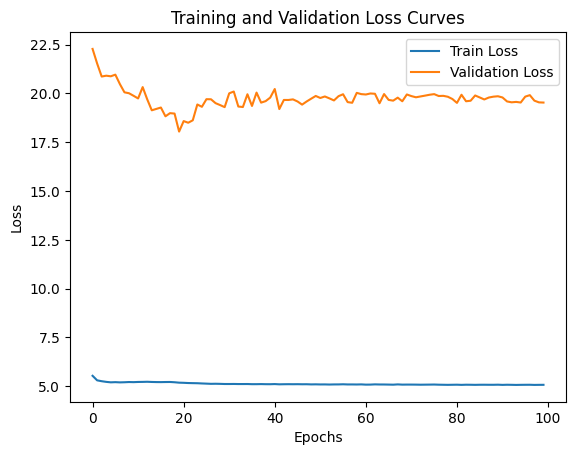

Training Complete.


In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import time  # To measure performance
from tqdm import tqdm  # For progress bar
import os
import matplotlib.pyplot as plt

# GPU Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Verify Dataset
print("Verifying dataset...")
try:
    for idx, (x1, x2, label) in enumerate(dataset):
        print(f"Sample {idx}: x1 shape {x1.shape}, x2 shape {x2.shape}, label shape {label.shape}")
        break  
except Exception as e:
    print(f"Error in dataset: {e}")

# Set a random seed for reproducibility
torch.manual_seed(42)

# Train-Validation Split
train_ratio = 0.8  # 80% for training, 20% for validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader Optimization
print("Setting up DataLoaders...")
try:
    batch_size = 64  # Updated batch size
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

except Exception as e:
    print(f"Error creating DataLoaders: {e}")
    exit()

# Increase model regularization
model = ContrastiveLSTMModel(input_dim=1, hidden_dim=64, output_dim=32, dropout=0.3).to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5) 


# Training Loop
epochs = 100
train_losses = []
val_losses = []

# Optimizer and OneCycleLR Scheduler
total_steps = len(dataloader) * epochs
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.005, total_steps=total_steps
)
print("Starting Training...")

for epoch in range(epochs):
    torch.cuda.empty_cache()  
    start_time = time.time()
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0

    #Training Phase
    print(f"\nEpoch {epoch+1}/{epochs} - Training Phase Started...")
    model.train()
    for batch_idx, (x1, x2, label) in enumerate(tqdm(dataloader, desc=f"Training Epoch {epoch+1}")):
        try:
            # Move data to GPU
            x1, x2 = x1.to(device, dtype=torch.float32), x2.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            # Reshape inputs and apply data augmentation
            x1 = data_augmentation(x1.unsqueeze(-1))
            x2 = data_augmentation(x2.unsqueeze(-1))

            # Forward Pass
            z1 = model(x1)
            z2 = model(x2)

            # Normalize Embeddings
            z1 = z1 / (torch.norm(z1, p=2, dim=-1, keepdim=True) + 1e-8)
            z2 = z2 / (torch.norm(z2, p=2, dim=-1, keepdim=True) + 1e-8)

            # Compute Loss
            loss = contrastive_loss_fn(z1, z2, label)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()

            # Gradient Clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            # Optimizer Step and Scheduler Step
            optimizer.step()
            if scheduler.last_epoch < scheduler.total_steps:
                scheduler.step()


            epoch_train_loss += loss.item()
        except Exception as e:
            print(f"Error during training batch {batch_idx}: {e}")
            continue

    train_losses.append(epoch_train_loss / len(dataloader))

    #Validation Phase
    print(f"\nEpoch {epoch+1}/{epochs} - Validation Phase Started...")
    model.eval()
    with torch.no_grad():
        for batch_idx, (x1, x2, label) in enumerate(tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}")):
            try:
                # Move data to GPU
                x1, x2 = x1.to(device, dtype=torch.float32), x2.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.long)

                # Reshape inputs
                x1 = x1.unsqueeze(-1)
                x2 = x2.unsqueeze(-1)

                # Forward Pass
                z1 = model(x1)
                z2 = model(x2)
                z1 = z1 / (torch.norm(z1, p=2, dim=-1, keepdim=True) + 1e-8)
                z2 = z2 / (torch.norm(z2, p=2, dim=-1, keepdim=True) + 1e-8)
                loss = contrastive_loss_fn(z1, z2, label)

                epoch_val_loss += loss.item()
            except Exception as e:
                print(f"Error during validation batch {batch_idx}: {e}")
                continue

    val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(val_loss)

    #Print Epoch Metrics
    end_time = time.time()
    print(f"Epoch {epoch+1}/{epochs} | "
          f"Training Loss: {epoch_train_loss / len(dataloader):.4f} | "
          f"Validation Loss: {val_loss:.4f} | "
          f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Time: {end_time - start_time:.2f}s")

# Plot Loss Curves
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

print("Training Complete.")


### Downstream Task Preparation and Evaluation

In [60]:
def extract_model_embeddings(model, dataloader, device, print_sample=False):
    model.eval()
    embeddings, labels = [], []

    with torch.no_grad():
        for idx, (x1, x2, label) in tqdm(enumerate(dataloader), desc="Extracting Embeddings"):
            x1 = x1.to(device)
            z1 = model(x1.unsqueeze(-1))  
            embeddings.append(z1.cpu())
            labels.append(label.cpu())

            if print_sample and idx == 0:
                print("Sample Embedding:", z1[0][:5])

    embeddings = torch.cat(embeddings, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy().ravel()  
    return embeddings, labels


In [61]:
def visualize_embeddings(embeddings, labels, title="t-SNE Visualization"):

    tsne = TSNE(n_components=2, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Labels")
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.show()


In [62]:
def perform_classification(embeddings, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42
    )

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Compute Metrics
    auc_roc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print("\nClassification Task Metrics:")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print("Confusion Matrix:\n", cm)

    return y_test, y_pred, y_proba, cm


In [63]:
def perform_regression(embeddings, labels):
    X_train, X_test, y_train, y_test = train_test_split(
        embeddings, labels, test_size=0.2, random_state=42
    )

    reg = Ridge(alpha=1.0)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\nRegression Task Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"R-Squared: {r2:.4f}")


Extracting Train Embeddings...


Extracting Embeddings: 0it [00:00, ?it/s]

Sample Embedding: tensor([-0.9680,  1.1330,  0.0828,  0.1741,  0.0409], device='cuda:0')


Extracting Embeddings: 519it [00:02, 184.49it/s]


Extracting Validation Embeddings...


Extracting Embeddings: 130it [00:00, 199.10it/s]


Unique Labels in Combined Dataset: [0. 1.]

Visualizing Embeddings...


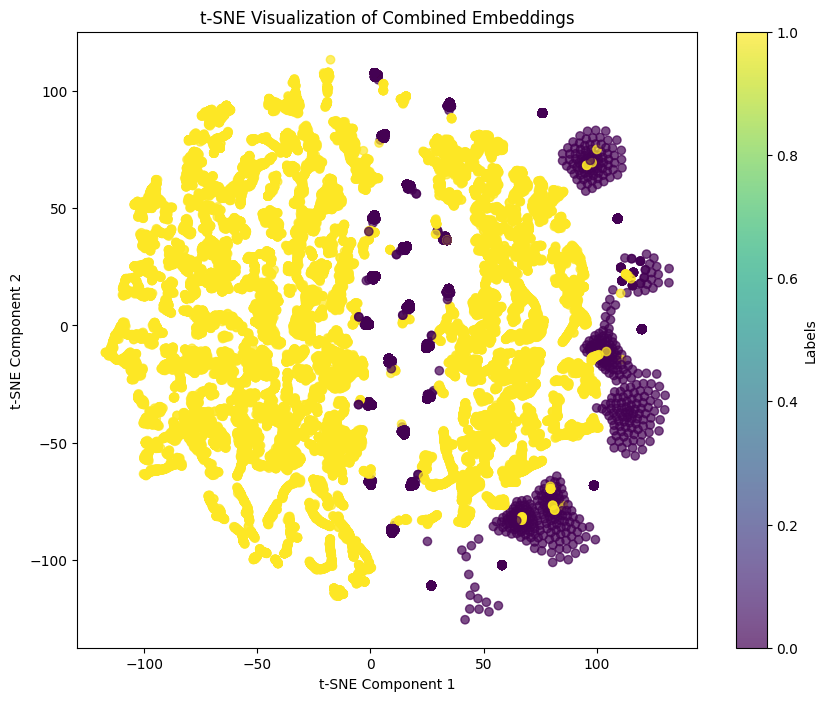


Performing Classification Task...

Classification Task Metrics:
AUC-ROC: 0.8030
Accuracy: 0.8214
F1-Score: 0.8793
Recall: 0.9320
Precision: 0.8323
Confusion Matrix:
 [[1417 1088]
 [ 394 5400]]

Performing Regression Task...

Regression Task Metrics:
Mean Squared Error (MSE): 0.1449
R-Squared: 0.3125


In [64]:
if __name__ == "__main__":
    # Extract Train Embeddings
    print("Extracting Train Embeddings...")
    train_embeddings, train_labels = extract_model_embeddings(model, dataloader, device, print_sample=True)

    # Extract Validation Embeddings
    print("Extracting Validation Embeddings...")
    val_embeddings, val_labels = extract_model_embeddings(model, val_dataloader, device)

    # Combine embeddings and labels
    combined_embeddings = np.vstack((train_embeddings, val_embeddings))
    combined_labels = np.concatenate((train_labels, val_labels))
    print("Unique Labels in Combined Dataset:", np.unique(combined_labels))

    # Visualize Combined Embeddings
    print("\nVisualizing Embeddings...")
    visualize_embeddings(combined_embeddings, combined_labels, title="t-SNE Visualization of Combined Embeddings")

    # Perform Classification
    print("\nPerforming Classification Task...")
    y_test, y_pred, y_proba, cm = perform_classification(combined_embeddings, combined_labels)

    # Perform Regression
    print("\nPerforming Regression Task...")
    perform_regression(combined_embeddings, combined_labels)


### Pipeline and Practical Implementation

In [65]:
# Extract embeddings using your trained model
train_embeddings, train_labels = extract_model_embeddings(model, dataloader, device)
val_embeddings, val_labels = extract_model_embeddings(model, val_dataloader, device)

# Combine train and validation embeddings
combined_embeddings = np.vstack((train_embeddings, val_embeddings))
combined_labels = np.concatenate((train_labels, val_labels), axis=0)

print("Combined Embedding Shape:", combined_embeddings.shape)
print("Combined Labels Shape:", combined_labels.shape)


Extracting Embeddings: 519it [00:02, 200.75it/s]
Extracting Embeddings: 130it [00:00, 130.30it/s]

Combined Embedding Shape: (41494, 32)
Combined Labels Shape: (41494,)


In [66]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    combined_embeddings, combined_labels, test_size=0.2, random_state=42
)

# Train a logistic regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.56      0.66      2509
         1.0       0.83      0.94      0.88      5790

    accuracy                           0.82      8299
   macro avg       0.81      0.75      0.77      8299
weighted avg       0.82      0.82      0.81      8299

Confusion Matrix:
[[1411 1098]
 [ 376 5414]]


In [67]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# Example: If your labels are continuous, perform regression
X_train, X_test, y_train, y_test = train_test_split(
    combined_embeddings, combined_labels, test_size=0.2, random_state=42
)

# Train a Ridge Regression model
reg = Ridge(alpha=1.0)
reg.fit(X_train, y_train)

# Predict and evaluate
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-Squared: {r2:.4f}")


Mean Squared Error (MSE): 0.1453
R-Squared: 0.3110


#### Clustering

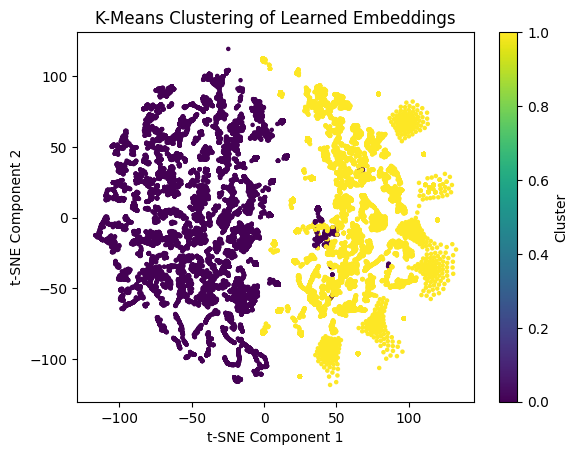

In [68]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Perform K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(combined_embeddings)

# Visualize the clusters using t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(combined_embeddings)

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap="viridis", s=5)
plt.colorbar(label="Cluster")
plt.title("K-Means Clustering of Learned Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


#### Merging embeddings

In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import os

# Define the path to the extracted mimiciii folder
current_directory = os.getcwd()
final_folder = os.path.join(current_directory, "mimiciii")

# Ensure the extracted folder exists
if not os.path.exists(final_folder):
    raise FileNotFoundError(f"Error: The folder '{final_folder}' does not exist. Please ensure the extraction was completed successfully.")

# Load Clinical Tables
admissions = pd.read_csv(os.path.join(final_folder, "ADMISSIONS.csv"))  # Contains mortality (hospital_expire_flag)

# Prepare Mortality Labels
mortality_df = admissions[['subject_id', 'hospital_expire_flag']].dropna()

# Use Combined Embeddings
embedding_dim = combined_embeddings.shape[1]
embeddings_df = pd.DataFrame(combined_embeddings, columns=[f"dim_{i}" for i in range(embedding_dim)])
embeddings_df['subject_id'] = combined_labels  # Assuming `combined_labels` corresponds to subject IDs

# Merge Mortality and Embeddings
mortality_merged = pd.merge(embeddings_df, mortality_df, on='subject_id', how='inner')
print("\nMerged Mortality DataFrame:")
print(mortality_merged.head())



Merged Mortality DataFrame:
Empty DataFrame
Columns: [dim_0, dim_1, dim_2, dim_3, dim_4, dim_5, dim_6, dim_7, dim_8, dim_9, dim_10, dim_11, dim_12, dim_13, dim_14, dim_15, dim_16, dim_17, dim_18, dim_19, dim_20, dim_21, dim_22, dim_23, dim_24, dim_25, dim_26, dim_27, dim_28, dim_29, dim_30, dim_31, subject_id, hospital_expire_flag]
Index: []

[0 rows x 34 columns]


In [98]:
print("Unique subject_ids in embeddings_df:", embeddings_df['subject_id'].unique())
print("Unique subject_ids in los_df:", los_df['subject_id'].unique())
print(embeddings_df['subject_id'].dtype)
print(los_df['subject_id'].dtype)
common_subjects = set(embeddings_df['subject_id']).intersection(set(los_df['subject_id']))
print("Number of common subject_ids:", len(common_subjects))
if common_subjects:
    print("Sample common subject_ids:", list(common_subjects)[:5])
else:
    print("No common subject_ids found.")


Unique subject_ids in embeddings_df: [0. 1.]
Unique subject_ids in los_df: [10006 10011 10013 10017 10019 10026 10027 10029 10032 10033 10035 10036
 10038 10040 10042 10043 10044 10045 10046 10056 10059 10061 10064 10065
 10067 10069 10074 10076 10083 10088 10089 10090 10093 10094 10098 10101
 10102 10104 10106 10111 10112 10114 10117 10119 10120 10124 10126 10127
 10130 10132 40124 40177 40204 40277 40286 40304 40310 40456 40503 40595
 40601 40612 40655 40687 41795 41914 41976 41983 42033 42066 42075 42135
 42199 42231 42275 42281 42292 42302 42321 42346 42367 42412 42430 42458
 43735 43746 43748 43779 43798 43827 43870 43879 43881 43909 43927 44083
 44154 44212 44222 44228]
float32
int64
Number of common subject_ids: 0
No common subject_ids found.


#### ICU Mortality Prediction


ICU Mortality Prediction Metrics:
Accuracy: 0.6925
AUC-ROC: 0.5046
Confusion Matrix:
 [[7414    0]
 [3292    0]]


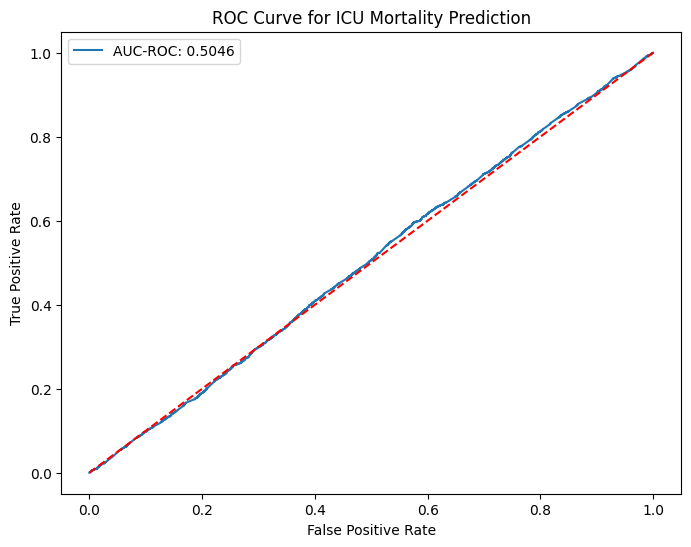

In [93]:
# Step 1: Merge Embeddings with Mortality Data
mortality_embeddings = embeddings_df.merge(mortality_df, on="subject_id", how="inner")
if mortality_embeddings.empty:
    raise ValueError("No matching data found for merging embeddings with mortality data.")

# Step 2: Prepare Features and Target for Mortality Prediction
X_mortality = mortality_embeddings.drop(columns=['subject_id', 'hospital_expire_flag'])  # Features
y_mortality = mortality_embeddings['hospital_expire_flag']  # Target: Mortality

# Step 3: Split Data
X_train, X_test, y_train, y_test = train_test_split(X_mortality, y_mortality, test_size=0.2, random_state=42)

# Step 4: Train Logistic Regression Model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Step 5: Predict and Evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("\nICU Mortality Prediction Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("Confusion Matrix:\n", cm)

# Step 6: Visualization - ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC: {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ICU Mortality Prediction")
plt.legend()
plt.show()

#### ICU Readmission Prediction

Replaced placeholder subject IDs to match length of combined_embeddings_df.
Sample subject_ids in combined_embeddings_df after replacement:
0    10006
1    10011
2    10013
3    10017
4    10019
Name: subject_id, dtype: int64
Readmission Embeddings Shape: (44399, 34)

ICU Readmission Prediction Metrics:
Accuracy: 0.9377
AUC-ROC: 0.4901
Confusion Matrix:
 [[   0  553]
 [   0 8327]]


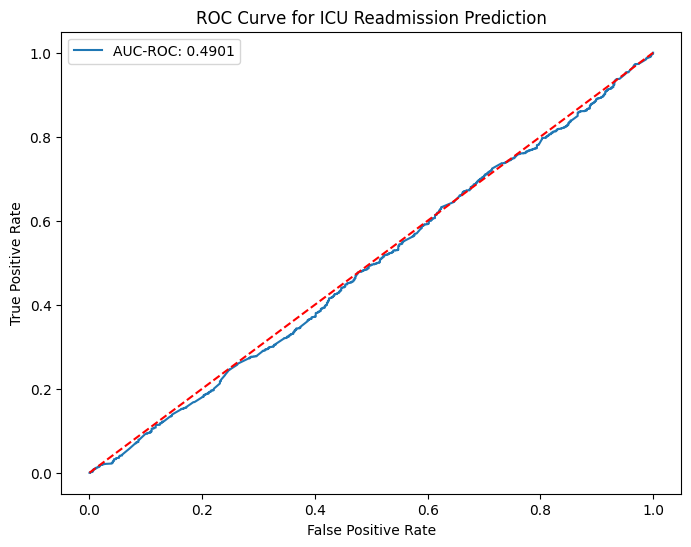

In [95]:
# Step 1: Replace Placeholder IDs to Match DataFrame Length
real_subject_ids = np.tile(readmission_df['subject_id'].unique(), (len(combined_embeddings_df) // len(readmission_df['subject_id'].unique()) + 1))[:len(combined_embeddings_df)]

combined_embeddings_df['subject_id'] = real_subject_ids
print("Replaced placeholder subject IDs to match length of combined_embeddings_df.")

# Step 2: Verify the Replacement
print("Sample subject_ids in combined_embeddings_df after replacement:")
print(combined_embeddings_df['subject_id'].head())

# Step 3: Merge Readmission Data
readmission_embeddings = combined_embeddings_df.merge(readmission_df, on="subject_id", how="inner")
print("Readmission Embeddings Shape:", readmission_embeddings.shape)

# Step 4: Prepare Features and Target
X_readmission = readmission_embeddings.drop(columns=['subject_id', 'readmission_flag'])
y_readmission = readmission_embeddings['readmission_flag']

# Train Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(X_readmission, y_readmission, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Evaluate Classification Model
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("\nICU Readmission Prediction Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print("Confusion Matrix:\n", cm)

# Visualization: ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC-ROC: {auc_roc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="red")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for ICU Readmission Prediction")
plt.legend()
plt.show()
